In [1]:
#!/usr/bin/env python
import argparse
import os
import torch
import numpy as np
import matplotlib
# matplotlib.use('Agg')  # or "TkAgg" / "WXAgg" / "MacOSX"
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap.umap_ as umap
from torch.utils.data import DataLoader
from mpl_toolkits.mplot3d import Axes3D  # This registers the 3D projection, even if not used directly
# Import dataset and Featurizer function
# from domainbed.networks import Featurizer
# from domainbed import datasets
# from domainbed import hparams_registry
# from domainbed import algorithms, hparams_registry
# from domainbed.lib import misc
# from domainbed.lib.fast_data_loader import InfiniteDataLoader, FastDataLoader
import pickle
from itertools import product

import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import seaborn as sns
import pandas as pd

from mpl_sizes import get_format

# formatter = get_format("NeurIPS") # options: ICLR, ICML, NeurIPS, InfThesis

%matplotlib inline

/home/haozhesi/anaconda3/envs/sat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_envs = list(range(0, 5))
datasets = ['ColoredMNIST','RotatedMNIST','VLCS','PACS','OfficeHome','DomainNet']
algorithms = ['ERM', 'CMA','Fish','Fishr']

algorithm = 'CMA'
dataset = 'ColoredMNIST'
test_env = 0

json_file_name = f"/home/yuen_chen/DomainBed/domainbed/uai_plot_{dataset}_{algorithm}_testenv{test_env}.pkl/results.jsonl"

In [3]:
import json
import os
import matplotlib.pyplot as plt

def plot_all_metrics(json_file, test_env=0, train_envs=None):
    """
    Reads one results.jsonl file, plots:
      1) first_moment_diff, second_moment_diff, env{test_env}_out_acc (3-subplot figure)
      2) out-accuracy lines for all envs in train_envs + [test_env], distinguishing test env style.

    Parameters
    ----------
    json_file : str
        Path to the results.jsonl file containing lines of JSON with keys like:
        "step", "first_moment_diff", "second_moment_diff", "env{X}_out_acc", etc.
    test_env : int
        The single test env index to highlight in the first 3-subplot figure,
        and to style differently in the second figure.
    train_envs : list of ints
        The environment indices considered training envs (for the second figure line style).
    """

    if train_envs is None:
        train_envs = []  # default empty if not provided

    # 1) Prepare lists for first figure (FMD, SMD, out_acc for a single test_env)
    steps_1f = []
    first_moment_diff_list = []
    second_moment_diff_list = []
    testenv_out_acc_list = []

    # 2) Prepare a dictionary for all env out-acc lines
    #    We'll gather for train_envs + [test_env]
    all_envs = list(set(train_envs + [test_env]))
    env_out_acc_data = {env_idx: [] for env_idx in all_envs}  # each env -> list of (step, out_acc)

    # 3) Read JSON lines
    with open(json_file, 'r') as f:
        for line in f:
            data = json.loads(line)
            step = data.get('step')
            if step is None:
                continue

            # For first figure
            steps_1f.append(step)
            fmd_val = data.get('first_moment_diff', None)
            smd_val = data.get('second_moment_diff', None)
            # fmd_val = data.get('grad_pen', None)
            # smd_val = data.get('hess_pen', None)
            first_moment_diff_list.append(fmd_val)
            second_moment_diff_list.append(smd_val)

            # single test env out-acc
            out_acc_key = f"env{test_env}_out_acc"
            out_acc_val = data.get(out_acc_key, None)
            testenv_out_acc_list.append(out_acc_val)

            # For second figure (all env out acc)
            for env_idx in all_envs:
                key = f"env{env_idx}_out_acc"
                if key in data:
                    env_out_acc_data[env_idx].append((step, data[key]))

    # ---------------------
    # Figure 1: 3-subplot (FMD, SMD, env{test_env}_out_acc)
    # ---------------------
    plt.figure(figsize=(10, 8))

    print(steps_1f, first_moment_diff_list)
    # Subplot 1: First Moment Diff
    plt.subplot(3, 1, 1)
    plt.plot(steps_1f, first_moment_diff_list, label='First Moment Diff', marker='o')
    plt.title(f"{json_file} (Test Env: {test_env})")
    plt.ylabel('FMD')
    plt.legend()

    # Subplot 2: Second Moment Diff
    plt.subplot(3, 1, 2)
    plt.plot(steps_1f, second_moment_diff_list, label='Second Moment Diff', color='orange', marker='s')
    plt.ylabel('SMD')
    plt.legend()
    # -----------------------------------------------------------------
    # Subplot 3: All env out-acc lines (training vs. test)
    # -----------------------------------------------------------------
    plt.subplot(3, 1, 3)

    for env_idx in sorted(env_out_acc_data.keys()):
        # sort by step
        data_pairs = sorted(env_out_acc_data[env_idx], key=lambda x: x[0])
        env_steps = [pair[0] for pair in data_pairs]
        env_accs = [pair[1] for pair in data_pairs]

        # Distinguish test env vs. train env
        if env_idx == test_env:
            label = f"Test Env {env_idx}"
            style = '--'
            color = 'red'
            marker = 'o'
        else:
            label = f"Train Env {env_idx}"
            style = '-'
            color = None
            marker = None

        plt.plot(env_steps, env_accs, linestyle=style, label=label, color=color, marker=marker)

    plt.xlabel("Training Step")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
# ------------------
# Example usage:
# plot_all_metrics("./domainbed/results.jsonl", test_env=1, train_envs=[0,2])
# ------------------


In [4]:
all_envs = list(range(0, 4))
datasets = ['ColoredMNIST','RotatedMNIST','VLCS','PACS','OfficeHome','DomainNet']
algorithms = ['ERM', 'CMA','Fish','Fishr']

# Example picks
algorithm = 'ERM'
dataset = 'VLCS'
test_env = 3
train_envs = [env for env in all_envs if env != test_env]

# Suppose your results are in:
json_file_name = f"/home/yuen_chen/DomainBed/domainbed/uai_plot_{dataset}_{algorithm}_testenv{test_env}/results.jsonl"
if not os.path.exists(json_file_name):
    print(f"File not found: {json_file_name}")
else:
    # plot_all_metrics(json_file_name, test_env=test_env, train_envs=train_envs)
    pass



In [5]:
all_envs = list(range(0, 4))
datasets = ['ColoredMNIST','RotatedMNIST','VLCS','PACS','OfficeHome','DomainNet']
algorithms = ['ERM', 'CMA','Fish','Fishr']

# Example picks
algorithm = 'CMA'
dataset = 'VLCS'
test_env = 3
train_envs = [env for env in all_envs if env != test_env]

# Suppose your results are in:
json_file_name = f"/home/yuen_chen/DomainBed/domainbed/uai_plot_{dataset}_{algorithm}_testenv{test_env}/results.jsonl"
if not os.path.exists(json_file_name):
    print(f"File not found: {json_file_name}")
else:
    # plot_all_metrics(json_file_name, test_env=test_env, train_envs=train_envs)
    pass



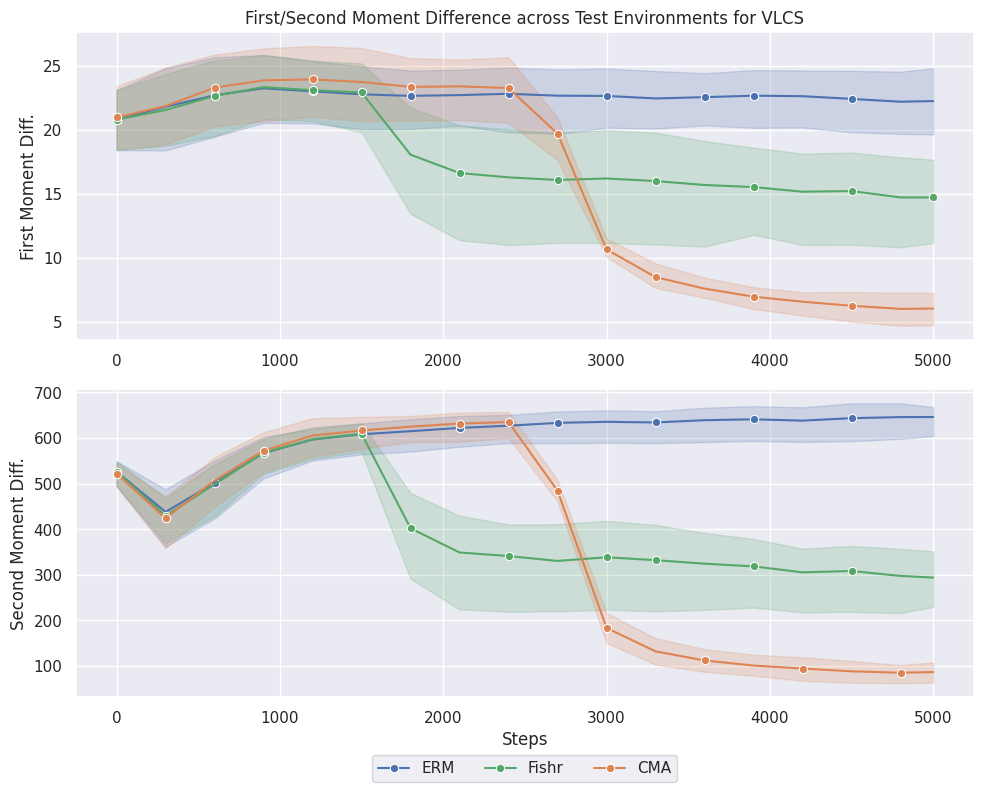

In [ ]:
import json
import os
import matplotlib.pyplot as plt

def read_results(json_file, test_env):
    """
    Reads a single results.jsonl file and returns:
    - steps: array of training steps
    - fmd_list: first_moment_diff per step
    - smd_list: second_moment_diff per step
    - test_out_acc_list: env{test_env}_out_acc per step
    If the file or certain keys are missing, arrays may contain None.
    """
    steps = []
    fmd_list = []
    smd_list = []
    test_out_acc_list = []

    with open(json_file, 'r') as f:
        for line in f:
            data = json.loads(line)
            step = data.get('step')
            if step is None:
                continue

            steps.append(step)
            # first_moment_diff & second_moment_diff
            fmd_val = data.get('first_moment_diff', None)
            smd_val = data.get('second_moment_diff', None)
            fmd_list.append(fmd_val)
            smd_list.append(smd_val)

            # test domain out-acc
            test_key = f"env{test_env}_out_acc"
            test_out_acc_list.append(data.get(test_key, None))

    # In case steps are out-of-order, let's sort by step
    # But we need to keep them aligned with fmd_list, smd_list, test_out_acc_list
    combined = list(zip(steps, fmd_list, smd_list, test_out_acc_list))
    combined.sort(key=lambda x: x[0])  # sort by step
    steps_sorted, fmd_sorted, smd_sorted, test_acc_sorted = zip(*combined)

    return list(steps_sorted), list(fmd_sorted), list(smd_sorted), list(test_acc_sorted)

def plot_algorithms_comparison(dataset, test_envs, algorithms, base_dir="/home/yuen_chen/DomainBed/domainbed/uai_plot"):
    """
    For a given dataset & test_env, loops over multiple algorithms,
    reads the corresponding results.jsonl, and plots a single figure 
    with 3 subplots:
      1) FMD vs. step (all algorithms)
      2) SMD vs. step (all algorithms)
      3) Test domain accuracy vs. step (all algorithms)
    """

    # We'll store each algorithm's curves in a dictionary
    results_by_algo = {}
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']  # adjust if more algos
    markers = ['o', 's', '^', 'D', 'x', '+']  # likewise, just for style variety

    # Build a figure
    plt.figure(figsize=(10, 8))
    dfs = []

    for test_env in test_envs:
        for idx, algo in enumerate(algorithms):
            json_file = os.path.join(f"{base_dir}_{dataset}_{algo}_testenv{test_env}", "results.jsonl")
            # if algo == 'CMA':
            #     json_file = os.path.join(f"{base_dir}_{dataset}_{algo}_testenv{test_env}_1500", "results.jsonl")
            if not os.path.exists(json_file):
                print(f"[SKIP] Not found: {json_file}")
                continue

            steps, fmd, smd, test_acc = read_results(json_file, test_env)
            if not steps:
                print(f"[SKIP] No valid 'step' data in {json_file}")
                continue
            
            # create df from steps, fmd, smd, test_acc
            df = pd.DataFrame({'step': steps, 'fmd': fmd, 'smd': smd, 'test_acc': test_acc, 'algorithm': algo, 'test_env': test_env})
            dfs.append(df)

        # We'll store them in a dictionary if we want, or just plot directly
        # label = f"{algo}"
        # c = colors[idx % len(colors)]
        # m = markers[idx % len(markers)]
    df = pd.concat(dfs)
    sns.set_theme()
    palette = sns.color_palette([sns.color_palette()[0], sns.color_palette()[2], sns.color_palette()[1]])
    
    plt.subplot(2, 1, 1)
    sns.lineplot(data=df, x='step', y='fmd', hue='algorithm', 
                marker='o', markersize=6, markevery=0.1, legend=False, palette=palette)
    plt.title(f"{dataset}, Test Env={test_env}\nFirst/Second Moment Diff and Test Acc across algorithms")
    
    # Subplot 2: SMD
    plt.subplot(2, 1, 2)
    sns.lineplot(data=df, x='step', y='smd', hue='algorithm',
                marker='o', markersize=6, markevery=0.1, palette=palette)

        # # Subplot 3: test domain out-acc
        # plt.subplot(3, 1, 3)
        # plt.plot(steps, test_acc, label=label, color=c, marker=m, markevery=0.1)

    # Now add titles, labels, legends
    # Subplot 1
    plt.subplot(2, 1, 1)
    plt.title(f"First/Second Moment Difference across Test Environments for {dataset}", fontsize=14, fontweight='bold')
    plt.ylabel("First Moment Diff.", fontsize=12, fontweight='bold')
    # remove x axis
    plt.xlabel('')
    # plt.legend()
    # remove legend
    # plt.legend([])

    # Subplot 2
    plt.subplot(2, 1, 2)
    plt.ylabel("Second Moment Diff.", fontsize=12, fontweight='bold')
    plt.xlabel('Steps', fontsize=12, fontweight='bold')
    # place the legend on the right side
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)

    plt.tight_layout()
    plt.show()

# -------------------------------
# Example usage:
if __name__ == "__main__":
    dataset = "VLCS"
    test_envs = [0, 1, 2, 3]
    algorithms = ['ERM', 'Fishr', 'CMA']
    # train_envs = [0,1,2] # not needed, we only want test domain in subplot 3

    plot_algorithms_comparison(dataset, test_envs, algorithms)
